# Importing Libraries

In [23]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm, trange

import tensorflow as tf
from tensorflow import keras
from keras import layers
import gc

import warnings
warnings.filterwarnings('ignore')

# Data Analysis

In [24]:
df = pd.read_csv('data/train_0.csv')
df.shape

(2149381, 61)

In [25]:
df.head()

,game_num,event_id,event_time,ball_pos_x,ball_pos_y,ball_pos_z,ball_vel_x,ball_vel_y,ball_vel_z,p0_pos_x,...,boost0_timer,boost1_timer,boost2_timer,boost3_timer,boost4_timer,boost5_timer,player_scoring_next,team_scoring_next,team_A_scoring_within_10sec,team_B_scoring_within_10sec
0,1,1002,-33.313030,-0.0,0.0,1.8548,-0.0,0.0,0.0,41.8048,...,0.0,0.0,0.0,0.0,0.0,0.0,3,B,0,0
1,1,1002,-33.206146,-0.0,0.0,1.8548,-0.0,0.0,0.0,42.2616,...,0.0,0.0,0.0,0.0,0.0,0.0,3,B,0,0
2,1,1002,-33.098114,-0.0,0.0,1.8548,-0.0,0.0,0.0,43.2270,...,0.0,0.0,0.0,0.0,0.0,0.0,3,B,0,0
3,1,1002,-32.993190,-0.0,0.0,1.8548,-0.0,0.0,0.0,43.8984,...,0.0,0.0,0.0,0.0,0.0,0.0,3,B,0,0
4,1,1002,-32.887756,-0.0,0.0,1.8548,-0.0,0.0,0.0,44.9606,...,0.0,0.0,0.0,0.0,0.0,0.0,3,B,0,0


#### Even if team_scoring_next is B the team_B_scoring_within_10sec is 0 this is because the event time is -33 that implies that there is still 33 sec in the game to come to an end. And the target column is about last 10sec this is why is contains 0.

Some of the important points regarding extra columns than the testing data is that:
* game_num, event_id, event_time these three are not there in the testing data.
* player_scoring_next or team_scoring_next contain informaton regarding the target variable.******

In [26]:
for col in df.columns:
    k = df[col].isnull().sum()
    if k > 0:
        print(col, '->', k)        

p0_pos_x -> 18991
p0_pos_y -> 18991
p0_pos_z -> 18991
p0_vel_x -> 18991
p0_vel_y -> 18991
p0_vel_z -> 18991
p0_boost -> 18991
p1_pos_x -> 18620
p1_pos_y -> 18620
p1_pos_z -> 18620
p1_vel_x -> 18620
p1_vel_y -> 18620
p1_vel_z -> 18620
p1_boost -> 18620
p2_pos_x -> 19517
p2_pos_y -> 19517
p2_pos_z -> 19517
p2_vel_x -> 19517
p2_vel_y -> 19517
p2_vel_z -> 19517
p2_boost -> 19517
p3_pos_x -> 19830
p3_pos_y -> 19830
p3_pos_z -> 19830
p3_vel_x -> 19830
p3_vel_y -> 19830
p3_vel_z -> 19830
p3_boost -> 19830
p4_pos_x -> 18531
p4_pos_y -> 18531
p4_pos_z -> 18531
p4_vel_x -> 18531
p4_vel_y -> 18531
p4_vel_z -> 18531
p4_boost -> 18531
p5_pos_x -> 19063
p5_pos_y -> 19063
p5_pos_z -> 19063
p5_vel_x -> 19063
p5_vel_y -> 19063
p5_vel_z -> 19063
p5_boost -> 19063
team_scoring_next -> 506604


### We will be removing team_scoring_next column any how and in the remaining columns removing 20000 data points from 2 million rows of data is not going to effect the model's performance much.

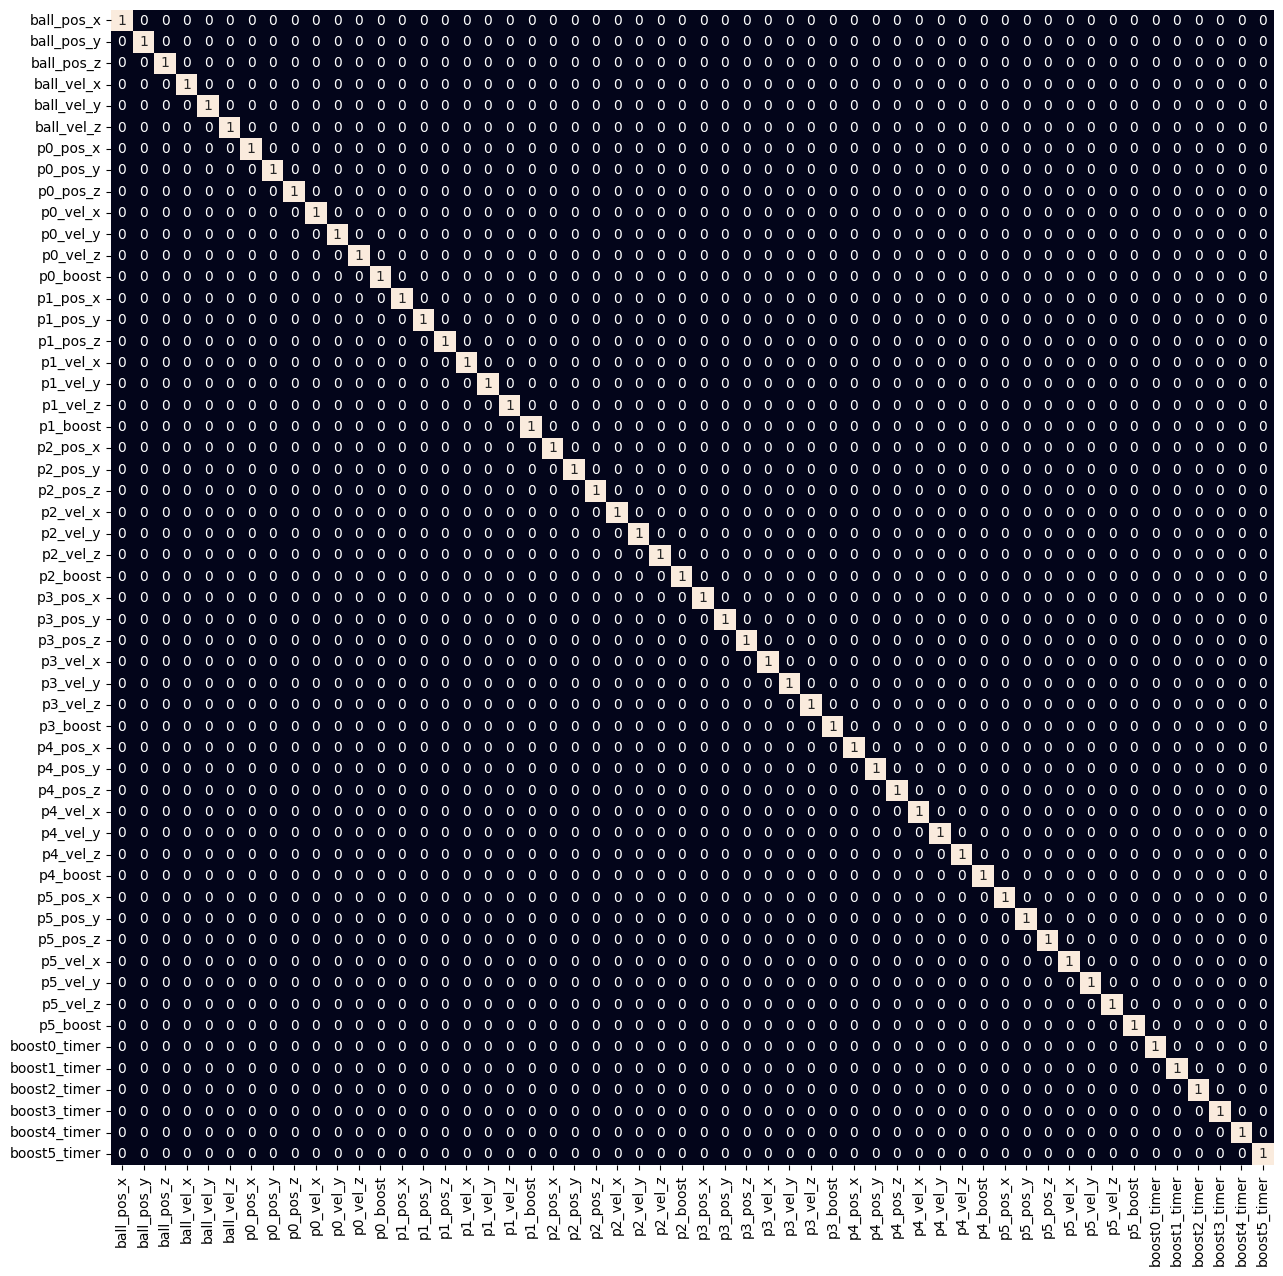

In [27]:
features = df.loc[:,'ball_pos_x':'boost5_timer']

plt.figure(figsize=(15,15))
sb.heatmap(features.corr() > 0.8, annot=True, cbar=False)
plt.show()

#### Here we can see that there are no highly correlated features here.

# Model Development

In [28]:
goal1_pos_x = 10
goal1_pos_y = -105
goal1_pos_z = 0

goal2_pos_x = -10
goal2_pos_y = -105
goal2_pos_z = 0

In [29]:
model = keras.models.Sequential([
    layers.Dense(256, activation='relu', input_shape=[38]),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam',
             loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             metrics=['AUC', 'accuracy'])

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 256)               9984      
                                                                 
 batch_normalization_6 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 256)               65792     
                                                                 
 batch_normalization_7 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 256)              

In [31]:
to_remove = ['game_num', 'event_id', 'event_time', 'player_scoring_next', 'team_scoring_next']

In [32]:
#calculate distance between ball and player
def distance(x1, y1, z1, x2, y2, z2):
    return np.sqrt((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2)

### In the logical XOR part what I have done is created an extra column which will contain 1 if none of the two teams has scored a goal in next 10 sec otherwise it will contain 0.

In [33]:
for i in range(10):
    path = f'data/train_{i}.csv'
    df = pd.read_csv(path)
    
    # Data loading and preprocessing 
    df['no_team_scored'] = np.logical_xor(df['team_A_scoring_within_10sec'],
                                          df['team_B_scoring_within_10sec'])
    df['no_team_scored'] = (~df['no_team_scored']).astype(int)
    
    df.drop(to_remove, axis=1, inplace=True)
    df.dropna(inplace=True, axis=0)
    
    features = df.loc[:,'ball_pos_x':'boost5_timer']
    target = df.loc[:,'team_A_scoring_within_10sec':'no_team_scored']

    #add distance column to train and test
    for j in range(0, 6):
        features[f'p{j}_dis_ball'] = distance(features['ball_pos_x'], features['ball_pos_y'], features['ball_pos_z'], features[f'p{j}_pos_x'], features[f'p{j}_pos_y'], features[f'p{j}_pos_z'])
        features[f'p{j}_dis_goal1'] = distance(goal1_pos_x, goal1_pos_y, goal1_pos_z, features[f'p{j}_pos_x'], features[f'p{j}_pos_y'], features[f'p{j}_pos_z'])
        features[f'p{j}_dis_goal2'] = distance(goal2_pos_x, goal2_pos_y, goal2_pos_z, features[f'p{j}_pos_x'], features[f'p{j}_pos_y'], features[f'p{j}_pos_z'])
    features[f'ball_dis_goal1'] = distance(goal1_pos_x, goal1_pos_y, goal1_pos_z, features[f'ball_pos_x'], features[f'ball_pos_y'], features[f'ball_pos_z'])
    features[f'ball_dis_goal2'] = distance(goal2_pos_x, goal2_pos_y, goal2_pos_z, features[f'ball_pos_x'], features[f'ball_pos_y'], features[f'ball_pos_z'])

    features[f't1_dis_ball'] = features[f'p0_dis_ball'] + features[f'p1_dis_ball'] + features[f'p2_dis_ball']
    features[f't1_dis_goal1'] = features[f'p0_dis_goal1'] + features[f'p1_dis_goal1'] + features[f'p2_dis_goal1']
    features[f't1_dis_goal2'] = features[f'p0_dis_goal2'] + features[f'p1_dis_goal2'] + features[f'p2_dis_goal2']

    features[f't2_dis_ball'] = features[f'p3_dis_ball'] + features[f'p4_dis_ball'] + features[f'p5_dis_ball']
    features[f't2_dis_goal1'] = features[f'p3_dis_goal1'] + features[f'p4_dis_goal1'] + features[f'p5_dis_goal1']
    features[f't2_dis_goal2'] = features[f'p3_dis_goal2'] + features[f'p4_dis_goal2'] + features[f'p5_dis_goal2']

    #remove unnecessary columns
    features.drop(['ball_pos_x', 'ball_pos_y', 'ball_pos_z', 'ball_vel_x', 'ball_vel_y', 'ball_vel_z'], axis=1, inplace=True)
    
    for j in range(0, 6):
        features.drop([f'p{j}_pos_x', f'p{j}_pos_y', f'p{j}_pos_z', f'p{j}_vel_x', f'p{j}_vel_y', f'p{j}_vel_z'], axis=1, inplace=True)
        
    X_train, X_val,\
    Y_train, Y_val = train_test_split(features, target,
                                      test_size = 0.03,
                                      random_state=22)
    
    print(f'Training on dataset number {i+1}.')
    
    model.fit(X_train, Y_train,
              batch_size=64,
              epochs=1,
              verbose=1,
              validation_data=(X_val, Y_val))
    
    del df, X_train, X_val, Y_train, Y_val
    gc.collect()
    print()

Training on dataset number 1.
30911/30911 [==============================] - 170s 5ms/step - loss: 0.4129 - auc: 0.9380 - accuracy: 0.8855 - val_loss: 0.4106 - val_auc: 0.9407 - val_accuracy: 0.8853

Training on dataset number 2.
31130/31130 [==============================] - 249s 8ms/step - loss: 0.3867 - auc: 0.9448 - accuracy: 0.8932 - val_loss: 0.4271 - val_auc: 0.9461 - val_accuracy: 0.8935

Training on dataset number 3.
30548/30548 [==============================] - 216s 7ms/step - loss: 0.3906 - auc: 0.9445 - accuracy: 0.8911 - val_loss: 0.3980 - val_auc: 0.9467 - val_accuracy: 0.8920

Training on dataset number 4.
30373/30373 [==============================] - 590s 19ms/step - loss: 0.4013 - auc: 0.9420 - accuracy: 0.8872 - val_loss: 0.4101 - val_auc: 0.9430 - val_accuracy: 0.8874

Training on dataset number 5.
30413/30413 [==============================] - 211s 7ms/step - loss: 0.3901 - auc: 0.9449 - accuracy: 0.8909 - val_loss: 0.3855 - val_auc: 0.9469 - val_accuracy: 0.8917


#### From the above training we can say that training on all the data has no effect on the accuracy as the accuracy score or AUC is stick to the 90% and 96% respectively.

## Predictions
One of the important factor here is predicting three classes B's score, A's Score and no ones score to get better results on the leaderboard. Due to this reason only sum of the probabilities for just A and B won't be equal to one.

In [34]:
df_test = pd.read_csv('data/test.csv')
df_test.shape

(701143, 55)

In [35]:
df_test.isnull().sum().sum()

261422

In [36]:
for col in df_test.columns:
    if df_test[col].isnull().sum() > 0:
        temp = df_test[col].mean()
        df_test[col] = df_test[col].fillna(temp)

df_test.isnull().sum().sum()

0

In [37]:
#add distance column to train and test
for i in range(0, 6):
    df_test[f'p{i}_dis_ball'] = distance(df_test['ball_pos_x'], df_test['ball_pos_y'], df_test['ball_pos_z'], df_test[f'p{i}_pos_x'], df_test[f'p{i}_pos_y'], df_test[f'p{i}_pos_z'])
    df_test[f'p{i}_dis_goal1'] = distance(goal1_pos_x, goal1_pos_y, goal1_pos_z, df_test[f'p{i}_pos_x'], df_test[f'p{i}_pos_y'], df_test[f'p{i}_pos_z'])
    df_test[f'p{i}_dis_goal2'] = distance(goal2_pos_x, goal2_pos_y, goal2_pos_z, df_test[f'p{i}_pos_x'], df_test[f'p{i}_pos_y'], df_test[f'p{i}_pos_z'])
df_test[f'ball_dis_goal1'] = distance(goal1_pos_x, goal1_pos_y, goal1_pos_z, df_test[f'ball_pos_x'], df_test[f'ball_pos_y'], df_test[f'ball_pos_z'])
df_test[f'ball_dis_goal2'] = distance(goal2_pos_x, goal2_pos_y, goal2_pos_z, df_test[f'ball_pos_x'], df_test[f'ball_pos_y'], df_test[f'ball_pos_z'])

df_test[f't1_dis_ball'] = df_test[f'p0_dis_ball'] + df_test[f'p1_dis_ball'] + df_test[f'p2_dis_ball']
df_test[f't1_dis_goal1'] = df_test[f'p0_dis_goal1'] + df_test[f'p1_dis_goal1'] + df_test[f'p2_dis_goal1']
df_test[f't1_dis_goal2'] = df_test[f'p0_dis_goal2'] + df_test[f'p1_dis_goal2'] + df_test[f'p2_dis_goal2']

df_test[f't2_dis_ball'] = df_test[f'p3_dis_ball'] + df_test[f'p4_dis_ball'] + df_test[f'p5_dis_ball']
df_test[f't2_dis_goal1'] = df_test[f'p3_dis_goal1'] + df_test[f'p4_dis_goal1'] + df_test[f'p5_dis_goal1']
df_test[f't2_dis_goal2'] = df_test[f'p3_dis_goal2'] + df_test[f'p4_dis_goal2'] + df_test[f'p5_dis_goal2']

In [38]:
#remove unnecessary columns
df_test.drop(['ball_pos_x', 'ball_pos_y', 'ball_pos_z', 'ball_vel_x', 'ball_vel_y', 'ball_vel_z'], axis=1, inplace=True)

for i in range(0, 6):
    df_test.drop([f'p{i}_pos_x', f'p{i}_pos_y', f'p{i}_pos_z', f'p{i}_vel_x', f'p{i}_vel_y', f'p{i}_vel_z'], axis=1, inplace=True)


In [39]:
df_test.head()

,id,p0_boost,p1_boost,p2_boost,p3_boost,p4_boost,p5_boost,boost0_timer,boost1_timer,boost2_timer,...,p5_dis_goal1,p5_dis_goal2,ball_dis_goal1,ball_dis_goal2,t1_dis_ball,t1_dis_goal1,t1_dis_goal2,t2_dis_ball,t2_dis_goal1,t2_dis_goal2
0,0,0.000,49.40,87.800,69.060000,83.10,71.00,0.0000,-3.264,-6.1330,...,170.874839,164.790736,150.949438,143.300038,123.395030,439.616587,418.416565,196.007582,581.693451,573.039828
1,1,0.784,34.50,0.000,45.683076,84.20,66.70,0.0000,-1.615,-5.9700,...,199.948115,203.824220,175.569945,175.894620,147.637212,468.789493,483.782413,115.186730,516.974384,522.128430
2,2,37.200,0.00,45.500,47.840000,23.14,80.40,-0.0316,0.000,0.0000,...,143.879998,146.216134,45.237507,64.351286,218.168216,194.177652,210.731997,211.372179,264.881969,295.913783
3,3,88.300,82.44,2.744,36.100000,49.03,96.06,-6.4300,-4.090,-7.8320,...,198.294397,200.018749,162.789222,167.197330,188.486881,449.898891,448.440399,164.773918,553.564417,551.990745
4,4,54.120,43.12,100.000,58.030000,85.50,0.00,-9.8800,0.000,-0.4456,...,104.532166,116.098397,64.959395,57.351783,122.206433,190.525755,147.242501,222.241358,345.714240,345.510533


In [45]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701143 entries, 0 to 701142
Data columns (total 39 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              701143 non-null  int64  
 1   p0_boost        701143 non-null  float64
 2   p1_boost        701143 non-null  float64
 3   p2_boost        701143 non-null  float64
 4   p3_boost        701143 non-null  float64
 5   p4_boost        701143 non-null  float64
 6   p5_boost        701143 non-null  float64
 7   boost0_timer    701143 non-null  float64
 8   boost1_timer    701143 non-null  float64
 9   boost2_timer    701143 non-null  float64
 10  boost3_timer    701143 non-null  float64
 11  boost4_timer    701143 non-null  float64
 12  boost5_timer    701143 non-null  float64
 13  p0_dis_ball     701143 non-null  float64
 14  p0_dis_goal1    701143 non-null  float64
 15  p0_dis_goal2    701143 non-null  float64
 16  p1_dis_ball     701143 non-null  float64
 17  p1_dis_goa

In [48]:
test = df_test.loc[:,'p0_boost':'t2_dis_goal2']
preds = model.predict(test)

 2234/21911 [==>...........................] - ETA: 13s

In [ ]:
preds = model.predict(test)

In [ ]:
preds.shape

(701143, 3)

In [ ]:
ss = pd.read_csv('data/sample_submission.csv')
ss['team_A_scoring_within_10sec'] = preds[:,0]
ss['team_B_scoring_within_10sec'] = preds[:,1]
ss.to_csv('Submission.csv', index=False)
ss.head()

,id,team_A_scoring_within_10sec,team_B_scoring_within_10sec
0,0,0.022139,0.027210
1,1,0.023654,0.074924
2,2,0.041196,0.126419
3,3,0.028533,0.039886
4,4,0.033850,0.029626


#### This will be our baseline score as we have done nothing but fit and predict on the training and testing data respectively. Let's see what feature engineering or different techniques could help us to get better results than this.